In [1]:
#!pip install tqdm
#!pip install progress
#!pip install sklearn

In [2]:
import tensorflow as tf
import sys
import math
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
#import cv2
import dataset_utils
#import inception_preprocessing
import inception_v3 as v3


from sklearn.model_selection import train_test_split
from tqdm import tqdm
#from getvector import getvector
from tensorflow.python.platform import gfile
from progress.bar import Bar
from math import floor, ceil, pi

from tensorflow.python.ops import control_flow_ops


%matplotlib inline



# Entrenamiento

## Generación de datos aumentados y extracción de características usando InceptionV3

En esta sección se realiza lo siguiente:
- Carga de mamografías según su clase.
- Aumentación de datos (flip horizontal, zoom)
- Extracción de vector de características usando InceptionV3

### Funciones para aumentación de datos

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#Ploteo de transformación
def plot_transform_steps(fig, tensor_image, fils = 1, cols = 1, pos = 1, title = "", show = False):
    with tf.Session() as sess:
        im = sess.run(tensor_image)
        #print(im)
        im = (im * 128 + 128) / 256
        
        ax = fig.add_subplot(fils, cols, pos)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        
        ax.imshow(im)
        ax.set_title(title)
        
    if show:
        plt.show()


def apply_with_random_selector(x, func, num_cases):
  """Computes func(x, sel), with sel sampled from [0...num_cases-1].

  Args:
    x: input Tensor.
    func: Python function to apply.
    num_cases: Python int32, number of cases to sample sel from.

  Returns:
    The result of func(x, sel), where func receives the value of the
    selector as a python integer, but sel is sampled dynamically.
  """
  sel = tf.random_uniform([], maxval=num_cases, dtype=tf.int32)
  # Pass the real x only to one of the func calls.
  return control_flow_ops.merge([
      func(control_flow_ops.switch(x, tf.equal(sel, case))[1], case)
      for case in range(num_cases)])[0]


def distort_color(image, color_ordering=0, fast_mode=True, scope=None):
  """Distort the color of a Tensor image.

  Each color distortion is non-commutative and thus ordering of the color ops
  matters. Ideally we would randomly permute the ordering of the color ops.
  Rather then adding that level of complication, we select a distinct ordering
  of color ops for each preprocessing thread.

  Args:
    image: 3-D Tensor containing single image in [0, 1].
    color_ordering: Python int, a type of distortion (valid values: 0-3).
    fast_mode: Avoids slower ops (random_hue and random_contrast)
    scope: Optional scope for name_scope.
  Returns:
    3-D Tensor color-distorted image on range [0, 1]
  Raises:
    ValueError: if color_ordering not in [0, 3]
  """
  with tf.name_scope(scope, 'distort_color', [image]):
    if fast_mode:
      if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
      else:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
    else:
      if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
      elif color_ordering == 1:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
      elif color_ordering == 2:
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
      elif color_ordering == 3:
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
      else:
        raise ValueError('color_ordering must be in [0, 3]')

    # The random_* ops do not necessarily clamp.
    return tf.clip_by_value(image, 0.0, 1.0)


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using a one of the bboxes randomly distorted.

  See `tf.image.sample_distorted_bounding_box` for more documentation.

  Args:
    image: 3-D Tensor of image (it will be converted to floats in [0, 1]).
    bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
      where each coordinate is [0, 1) and the coordinates are arranged
      as [ymin, xmin, ymax, xmax]. If num_boxes is 0 then it would use the whole
      image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
      area of the image must contain at least this fraction of any bounding box
      supplied.
    aspect_ratio_range: An optional list of `floats`. The cropped area of the
      image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `floats`. The cropped area of the image
      must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
      region of the image of the specified constraints. After `max_attempts`
      failures, return the entire image.
    scope: Optional scope for name_scope.
  Returns:
    A tuple, a 3-D Tensor cropped_image and the distorted bbox
  """
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    # Each bounding box has shape [1, num_boxes, box coords] and
    # the coordinates are ordered [ymin, xmin, ymax, xmax].

    # A large fraction of image datasets contain a human-annotated bounding
    # box delineating the region of the image containing the object of interest.
    # We choose to create a new bounding box for the object which is a randomly
    # distorted version of the human-annotated bounding box that obeys an
    # allowed range of aspect ratios, sizes and overlap with the human-annotated
    # bounding box. If no box is supplied, then we assume the bounding box is
    # the entire image.
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        tf.shape(image),
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, distort_bbox = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    cropped_image = tf.slice(image, bbox_begin, bbox_size)
    return cropped_image, distort_bbox


def preprocess_for_train(image, height, width, bbox, _plot_image, imagedir,
                         fast_mode=True,
                         scope=None):
  """Distort one image for training a network.

  Distorting images provides a useful technique for augmenting the data
  set during training in order to make the network invariant to aspects
  of the image that do not effect the label.

  Additionally it would create image_summaries to display the different
  transformations applied to the image.

  Args:
    image: 3-D Tensor of image. If dtype is tf.float32 then the range should be
      [0, 1], otherwise it would converted to tf.float32 assuming that the range
      is [0, MAX], where MAX is largest positive representable number for
      int(8/16/32) data type (see `tf.image.convert_image_dtype` for details).
    height: integer
    width: integer
    bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
      where each coordinate is [0, 1) and the coordinates are arranged
      as [ymin, xmin, ymax, xmax].
    fast_mode: Optional boolean, if True avoids slower transformations (i.e.
      bi-cubic resizing, random_hue or random_contrast).
    scope: Optional scope for name_scope.
  Returns:
    3-D float Tensor of distorted image used for training with range [-1, 1].
  """
  with tf.name_scope(scope, 'distort_image', [image, height, width, bbox]):
    if bbox is None:
      bbox = tf.constant([0.0, 0.0, 1.0, 1.0],
                         dtype=tf.float32,
                         shape=[1, 1, 4])
    if image.dtype != tf.float32:
      image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Each bounding box has shape [1, num_boxes, box coords] and
    # the coordinates are ordered [ymin, xmin, ymax, xmax].
    image_with_box = tf.image.draw_bounding_boxes(tf.expand_dims(image, 0), bbox)
    
    if _plot_image:
        fig = plt.figure() #figsize = (2, 3)
        fig.suptitle("Transformaciones aleatorias paso a paso: %s"%imagedir, fontsize=14)
    
    #print(image_with_box)
    if _plot_image:
        plot_transform_steps(fig, image_with_box[0], 2, 3, 1, "with_box", False)
    
    tf.summary.image('image_with_bounding_boxes', image_with_box)

    # Falta agregar rotación mínima aleatoria con cropping de fondo obligatorio

    #Añadido para no recortar demasiado las mamografías
    min_object_covered = 0.9
    distorted_image, distorted_bbox = distorted_bounding_box_crop(image, bbox, min_object_covered)
    # Restore the shape since the dynamic slice based upon the bbox_size loses
    # the third dimension.
    distorted_image.set_shape([None, None, 3])
    image_with_distorted_box = tf.image.draw_bounding_boxes(
        tf.expand_dims(image, 0), distorted_bbox)
    tf.summary.image('images_with_distorted_bounding_box',
                     image_with_distorted_box)
    if _plot_image:
        plot_transform_steps(fig, image_with_distorted_box[0], 2, 3, 2, "distort box", False)

    # This resizing operation may distort the images because the aspect
    # ratio is not respected. We select a resize method in a round robin
    # fashion based on the thread number.
    # Note that ResizeMethod contains 4 enumerated resizing methods.

    # We select only 1 case for fast_mode bilinear.
    num_resize_cases = 1 if fast_mode else 4
    distorted_image = apply_with_random_selector(
        distorted_image,
        lambda x, method: tf.image.resize_images(x, [height, width], method=method),
        num_cases=num_resize_cases)
    
    if _plot_image:
        plot_transform_steps(fig, distorted_image, 2, 3, 3, "resize met", False)

    tf.summary.image('cropped_resized_image',
                     tf.expand_dims(distorted_image, 0))

    # Randomly flip the image horizontally.
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    
    if _plot_image:
        plot_transform_steps(fig, distorted_image, 2, 3, 4, "hor flip", False)

    # Randomly distort the colors. There are 4 ways to do it.
    distorted_image = apply_with_random_selector(
        distorted_image,
        lambda x, ordering: distort_color(x, ordering, fast_mode),
        num_cases=4)
    
    if _plot_image:
        plot_transform_steps(fig, distorted_image, 2, 3, 5, "dist colors", False)

    tf.summary.image('final_distorted_image',
                     tf.expand_dims(distorted_image, 0))
    distorted_image = tf.subtract(distorted_image, 0.5)
    
    if _plot_image:
        plot_transform_steps(fig, distorted_image, 2, 3, 6, "substract", True)
    
    distorted_image = tf.multiply(distorted_image, 2.0)
    
    #print (distorted_image)
    return distorted_image


def preprocess_for_eval(image, height, width,
                        central_fraction=0.875, scope=None):
  """Prepare one image for evaluation.

  If height and width are specified it would output an image with that size by
  applying resize_bilinear.

  If central_fraction is specified it would cropt the central fraction of the
  input image.

  Args:
    image: 3-D Tensor of image. If dtype is tf.float32 then the range should be
      [0, 1], otherwise it would converted to tf.float32 assuming that the range
      is [0, MAX], where MAX is largest positive representable number for
      int(8/16/32) data type (see `tf.image.convert_image_dtype` for details)
    height: integer
    width: integer
    central_fraction: Optional Float, fraction of the image to crop.
    scope: Optional scope for name_scope.
  Returns:
    3-D float Tensor of prepared image.
  """
  with tf.name_scope(scope, 'eval_image', [image, height, width]):
    if image.dtype != tf.float32:
      image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Crop the central region of the image with an area containing 87.5% of
    # the original image.
    if central_fraction:
      image = tf.image.central_crop(image, central_fraction=central_fraction)

    if height and width:
      # Resize the image to the specified height and width.
      image = tf.expand_dims(image, 0)
      image = tf.image.resize_bilinear(image, [height, width],
                                       align_corners=False)
      image = tf.squeeze(image, [0])
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    return image


def preprocess_image(image, height, width,                     
                     is_training=False,
                     _plot_image=False, imagedir = '',
                     bbox=None,
                     fast_mode=True):
  """Pre-process one image for training or evaluation.

  Args:
    image: 3-D Tensor [height, width, channels] with the image.
    height: integer, image expected height.
    width: integer, image expected width.
    is_training: Boolean. If true it would transform an image for train,
      otherwise it would transform it for evaluation.
    bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
      where each coordinate is [0, 1) and the coordinates are arranged as
      [ymin, xmin, ymax, xmax].
    fast_mode: Optional boolean, if True avoids slower transformations.

  Returns:
    3-D float Tensor containing an appropriately scaled image

  Raises:
    ValueError: if user does not provide bounding box
  """
  if is_training:
    #print ("Preprocess for Training...")
    return preprocess_for_train(image, height, width, bbox, _plot_image, imagedir, fast_mode)
  else:
    #print ("Preprocess for Evaluation...")  
    return preprocess_for_eval(image, height, width)

### Funciones para Extracción de Características

In [4]:
#Vector que extrae las características
def getvector(imagedir, is_training = False, image_type = 'jpg', plot_image = False):
    slim = tf.contrib.slim
    
    batch_size = 3
    image_size = v3.inception_v3.default_image_size

    url = "http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz"
    checkpoints_dir = os.getcwd() + '/checkpoints'

    if not tf.gfile.Exists(checkpoints_dir + '/inception_v3.ckpt'):
        dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

    with tf.Graph().as_default():
        # imagedir = '/home/jiexun/Desktop/Siraj/ImageChallenge/Necessary/train/cat.0.jpg'
        image_string = tf.read_file(imagedir)
        
        if (image_type.lower() == 'jpg'):
            image = tf.image.decode_jpeg(image_string, channels=3)
        elif (image_type.lower() == 'png'):
            image = tf.image.decode_png(image_string, channels=3)
        else:
            return None
        
        #processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training)
        processed_image = preprocess_image(image, image_size, image_size, is_training, plot_image, imagedir)
        processed_images = tf.expand_dims(processed_image, 0)

        # Create the model, use the default arg scope to configure the batch norm parameters.
        #print('Inicializando el modelo InceptionV3...')
        with slim.arg_scope(v3.inception_v3_arg_scope()):
            num_classes=1001
            vector, _ = v3.inception_v3(processed_images, num_classes, is_training)
        
        
        init_fn = slim.assign_from_checkpoint_fn(os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
                                                 slim.get_model_variables('InceptionV3'))
        
        with tf.Session() as sess:
            init_fn(sess)
            np_image, vector = sess.run([image, vector])
            
            if plot_image:
                fig = plt.figure()
                fig.suptitle("Transformación a mamografía %s"%imagedir, fontsize=14)

                #Plotea la imagen original
                ax1 = fig.add_subplot(1,2,1)
                ax1.imshow(np_image)
                ax1.set_title("Original image")
                #plt.show()

                #Plotea la imagen procesada            
                im = sess.run(processed_image)
                im = (im * 128 + 128) / 256
                #print(im)
                ax2 = fig.add_subplot(1,2,2)
                ax2.imshow(im)
                ax2.set_title("Processed image")
                #plt.show()

                plt.show()

        a = np.asarray([x for xs in vector for xss in xs for xsss in xss for x in xsss])
        np.reshape(a, (1, 2048))

    return a

### Aumentación de datos y extracción de características

In [5]:
#Procesamiento
data_inputs = []
data_labels = []
factor_data_augmentation = 10
n_of_files_to_plot = 5
n_gen_samples_to_plot = 2

# Checking if the 2048-dimensional vector representations of the training images are already available
if os.path.isfile('./data/DM Images/data_inputs.txt') and os.path.isfile('./data/DM Images/data_labels.txt'):
    data_inputs = np.loadtxt('./data/DM Images/data_inputs.txt')
    data_labels = np.loadtxt('./data/DM Images/data_labels.txt')
    print('Datos cargados de un archivo.')

else: 
    #tf.reset_default_graph()
    # add in your images here if you want to train the model on your own images
    data_dir = 'data/DM Images/train'
    
    #Cuenta la cantidad de directorios/clases
    n_classes = 0
    for o in os.listdir(data_dir):
        if not o.startswith('.'):
            n_classes = n_classes + 1
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    i_class = 0
    for o in os.listdir(data_dir):
        if not o.startswith('.'):     
            class_name = os.path.join(o)
            print("Clase: ", class_name, "Índice: ",  i_class)

            file_list = []
            file_glob = os.path.join(data_dir, class_name, '*.jpg');
            print('File glob: ', file_glob)
            file_list.extend(gfile.Glob(file_glob))
            print('Samples: ', len(file_list))

            file_list = file_list[0:4]
            #bar = Bar('Inception-V3 is processing images:', max=300)
            #bar = Bar('Inception-V3 is processing images:', max=len(file_list))
            
            one_hot_row = np.zeros(n_classes)             
            one_hot_row[i_class] = 1
            print('one hot: ', one_hot_row)
            
            n_data_gen = len(file_list)*factor_data_augmentation
            pbar = tqdm(total=n_data_gen)
            pbar.set_description("\nExtrayendo características de %i muestras generadas de %s" % (n_data_gen, class_name))
            i = 0 #para contar cuántas mamografías por cada clase ploteo
            plot_image = False
            for file_name in file_list:
                #tqdm.write("Processing:  %s" % file_name)
                #Aumentación de datos y extracción de características
                if (i < n_of_files_to_plot):
                        plot_image = True                        
             
                j = 0
                for i in range(factor_data_augmentation):  
                    if (i < n_gen_samples_to_plot):
                        plot_image = True  
                    data_inputs.append(getvector(file_name, True, 'jpg', plot_image))
                    data_labels.append(one_hot_row)
                    pbar.update(1)
                    
                    plot_image = False
                    j = j + 1
                    
                plot_image = False
                i = i + 1
                #bar.next()
                
            i_class = i_class + 1
            pbar.close()
    #bar.finish()
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    np.savetxt('data/DM Images/data_inputs.txt', data_inputs)
    np.savetxt('data/DM Images/data_labels.txt', data_labels)
    
    print('Datos grabados en un archivo.')
    



Datos cargados de un archivo.


## Entrenamiento

### Se configuran los parámetros iniciales

In [6]:
# Splitting into train, val, and test
train_inputs, valtest_inputs, train_labels, valtest_labels = train_test_split(data_inputs, data_labels, test_size=0.3, random_state=42)
val_inputs, test_inputs, val_labels, test_labels = train_test_split(valtest_inputs, valtest_labels, test_size=0.4, random_state=43)

In [7]:
# Setting hyperparameters
learning_rate = 0.01
batch_size = 64
epochs = 100
log_batch_step = 50

In [8]:
# useful info
n_features = np.size(train_inputs, 1)
n_labels = np.size(train_labels, 1)

In [9]:
# Placeholders for input features and labels
inputs = tf.placeholder(tf.float32, (None, n_features))
labels = tf.placeholder(tf.float32, (None, n_labels))

In [10]:
# Setting up weights and bias
weights = tf.Variable(tf.truncated_normal((n_features, n_labels), stddev=0.1), name='weights')
bias = tf.Variable(tf.zeros(n_labels), name='bias')
tf.add_to_collection('vars', weights)
tf.add_to_collection('vars', bias)

In [11]:
# Setting up operation in fully connected layer
logits = tf.add(tf.matmul(inputs, weights), bias)
prediction = tf.nn.softmax(logits)
tf.add_to_collection('pred', prediction)

In [12]:
# Defining loss of network
difference = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss = tf.reduce_sum(difference)

In [13]:
# Setting optimiser
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [14]:
# Define accuracy
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

saver = tf.train.Saver((weights, bias))

### Carga del modelo InceptionV3

Aquí se debe realizar el transfer learning
(congelar las últimas capas del modelo y entrenar)

In [15]:
# Run tensorflow session
history = {'val_acc':[], 'val_loss':[]}
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Running the training in batches 
    batch_count = int(math.ceil(len(train_inputs)/batch_size))

    for epoch_i in range(epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{} '.format(epoch_i+1, epochs), unit='batches')
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_inputs = train_inputs[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            # Run optimizer
            _ = sess.run(optimizer, feed_dict={inputs: batch_inputs, labels: batch_labels})

        # Check accuracy against validation data
        val_accuracy, val_loss = sess.run([accuracy, loss], feed_dict={inputs: val_inputs, labels: val_labels})
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("After epoch {}, Loss: {}, Accuracy: {}".format(epoch_i+1, val_loss, val_accuracy))

    g = tf.get_default_graph()
    saver.save(sess, './data/dm-challenge')
    

Epoch 29/100 :   0%|          | 0/1 [00:00<?, ?batches/s]

After epoch 1, Loss: 79.2651138306, Accuracy: 0.5
After epoch 2, Loss: 48.0658988953, Accuracy: 0.5
After epoch 3, Loss: 13.3549156189, Accuracy: 0.428571432829
After epoch 4, Loss: 38.9066886902, Accuracy: 0.5
After epoch 5, Loss: 36.5632133484, Accuracy: 0.5
After epoch 6, Loss: 16.3588638306, Accuracy: 0.5
After epoch 7, Loss: 20.4080066681, Accuracy: 0.5
After epoch 8, Loss: 29.900724411, Accuracy: 0.5
After epoch 9, Loss: 22.3208274841, Accuracy: 0.5
After epoch 10, Loss: 11.2781467438, Accuracy: 0.571428596973
After epoch 11, Loss: 20.9768943787, Accuracy: 0.5
After epoch 12, Loss: 25.0120582581, Accuracy: 0.5
After epoch 13, Loss: 17.6884937286, Accuracy: 0.5
After epoch 14, Loss: 11.3404922485, Accuracy: 0.428571432829
After epoch 15, Loss: 17.8459682465, Accuracy: 0.5
After epoch 16, Loss: 19.1712493896, Accuracy: 0.5
After epoch 17, Loss: 13.1808815002, Accuracy: 0.428571432829
After epoch 18, Loss: 12.2347230911, Accuracy: 0.5
After epoch 19, Loss: 17.3885688782, Accuracy: 0

Epoch 57/100 : 100%|██████████| 1/1 [00:00<00:00, 611.24batches/s]


After epoch 29, Loss: 11.1847572327, Accuracy: 0.571428596973
After epoch 30, Loss: 11.6029119492, Accuracy: 0.428571432829
After epoch 31, Loss: 13.0227003098, Accuracy: 0.428571432829
After epoch 32, Loss: 12.4250974655, Accuracy: 0.5
After epoch 33, Loss: 11.0364255905, Accuracy: 0.428571432829
After epoch 34, Loss: 11.3810720444, Accuracy: 0.571428596973
After epoch 35, Loss: 12.6152133942, Accuracy: 0.5
After epoch 36, Loss: 12.542640686, Accuracy: 0.5
After epoch 37, Loss: 11.3600997925, Accuracy: 0.571428596973
After epoch 38, Loss: 10.876250267, Accuracy: 0.428571432829
After epoch 39, Loss: 11.4738454819, Accuracy: 0.571428596973
After epoch 40, Loss: 11.8433742523, Accuracy: 0.5
After epoch 41, Loss: 11.3499803543, Accuracy: 0.5
After epoch 42, Loss: 10.832118988, Accuracy: 0.428571432829
After epoch 43, Loss: 11.0568437576, Accuracy: 0.571428596973
After epoch 44, Loss: 11.5996904373, Accuracy: 0.5
After epoch 45, Loss: 11.6511011124, Accuracy: 0.5
After epoch 46, Loss: 11.1

Epoch 90/100 : 100%|██████████| 1/1 [00:00<00:00, 478.26batches/s]



After epoch 58, Loss: 10.7081871033, Accuracy: 0.571428596973
After epoch 59, Loss: 10.7872276306, Accuracy: 0.428571432829
After epoch 60, Loss: 10.8362607956, Accuracy: 0.428571432829
After epoch 61, Loss: 10.7846822739, Accuracy: 0.428571432829
After epoch 62, Loss: 10.7002229691, Accuracy: 0.428571432829
After epoch 63, Loss: 10.6844577789, Accuracy: 0.571428596973
After epoch 64, Loss: 10.7516078949, Accuracy: 0.714285731316
After epoch 65, Loss: 10.8244066238, Accuracy: 0.642857134342
After epoch 66, Loss: 10.8267669678, Accuracy: 0.642857134342
After epoch 67, Loss: 10.7590465546, Accuracy: 0.714285731316
After epoch 68, Loss: 10.6839227676, Accuracy: 0.642857134342
After epoch 69, Loss: 10.6549892426, Accuracy: 0.571428596973
After epoch 70, Loss: 10.6698455811, Accuracy: 0.428571432829
After epoch 71, Loss: 10.6874694824, Accuracy: 0.428571432829
After epoch 72, Loss: 10.6786003113, Accuracy: 0.428571432829
After epoch 73, Loss: 10.6526985168, Accuracy: 0.571428596973
After e

Epoch 100/100 : 100%|██████████| 1/1 [00:00<00:00, 465.57batches/s]


After epoch 91, Loss: 10.6213064194, Accuracy: 0.642857134342
After epoch 92, Loss: 10.6089878082, Accuracy: 0.642857134342
After epoch 93, Loss: 10.6002445221, Accuracy: 0.571428596973
After epoch 94, Loss: 10.5961885452, Accuracy: 0.571428596973
After epoch 95, Loss: 10.5946054459, Accuracy: 0.571428596973
After epoch 96, Loss: 10.5930461884, Accuracy: 0.571428596973
After epoch 97, Loss: 10.5911159515, Accuracy: 0.571428596973
After epoch 98, Loss: 10.5902614594, Accuracy: 0.571428596973
After epoch 99, Loss: 10.5917816162, Accuracy: 0.642857134342
After epoch 100, Loss: 10.595161438, Accuracy: 0.642857134342


## Métricas

{'val_acc': [0.5, 0.5, 0.42857143, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5714286, 0.5, 0.5, 0.5, 0.42857143, 0.5, 0.5, 0.42857143, 0.5, 0.5, 0.5, 0.5714286, 0.5, 0.42857143, 0.42857143, 0.42857143, 0.5, 0.5, 0.42857143, 0.5714286, 0.42857143, 0.42857143, 0.5, 0.42857143, 0.5714286, 0.5, 0.5, 0.5714286, 0.42857143, 0.5714286, 0.5, 0.5, 0.42857143, 0.5714286, 0.5, 0.5, 0.5714286, 0.64285713, 0.42857143, 0.5, 0.5, 0.42857143, 0.5714286, 0.71428573, 0.5714286, 0.5714286, 0.64285713, 0.71428573, 0.5714286, 0.42857143, 0.42857143, 0.42857143, 0.42857143, 0.5714286, 0.71428573, 0.64285713, 0.64285713, 0.71428573, 0.64285713, 0.5714286, 0.42857143, 0.42857143, 0.42857143, 0.5714286, 0.5714286, 0.64285713, 0.64285713, 0.71428573, 0.71428573, 0.64285713, 0.64285713, 0.5714286, 0.5714286, 0.5714286, 0.5714286, 0.5714286, 0.5714286, 0.64285713, 0.64285713, 0.64285713, 0.64285713, 0.64285713, 0.64285713, 0.5714286, 0.5714286, 0.5714286, 0.5714286, 0.5714286, 0.5714286, 0.64285713, 0.64285713], 'val_loss'

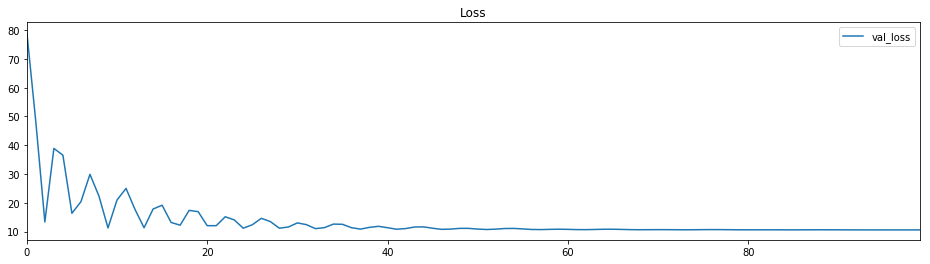

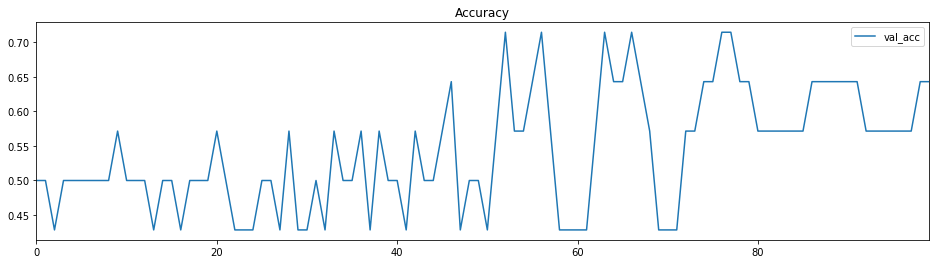

In [16]:
print(history)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(history)
#display(df)

df.plot(y=['val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['val_acc'], figsize=(16,4), title='Accuracy');

## Pruebas unitarias

In [17]:
def predict(prediction, file_name = ''):
    #try: 
    #    file_name = 'cat.jpg'
    #except IndexError:
    #    print ('please enter image file path.........')
    #    exit()
    image_input = getvector(file_name).reshape((1,2048))
    #if 'cat' in file_name:
    #    image_label = [[1, 0]]plot_image
    #else:
    #    image_label = [[0, 1]]

    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('./data/dm-challenge')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        pred = sess.run(prediction, feed_dict={inputs: image_input})

        return pred

In [18]:
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

pred = predict(prediction, 'data/DM Images/validation/Cancer/337671.jpg')
print('Predict: Cancer/337671.jpg\n', )
img=mpimg.imread('data/DM Images/validation/Cancer/337671.jpg')
imgplot = plt.imshow(img, cmap="gray")
plt.show()
print ('Cancer: {}, NoCancer: {}'.format(pred[0][0], pred[0][1]))
print('\n\n\n')

pred = predict(prediction, 'data/DM Images/validation/NoCancer/288567.jpg')
print('Predict: NoCancer/288567.jpg\n', )
img=mpimg.imread('data/DM Images/validation/NoCancer/288567.jpg')
imgplot = plt.imshow(img, cmap="gray")
plt.show()
print ('Cancer: {}, NoCancer: {}'.format(pred[0][0], pred[0][1]))


INFO:tensorflow:Restoring parameters from /home/christian/inf659-inception/transfer_learning/checkpoints/inception_v3.ckpt


IOError: File ./data/dm-challenge does not exist.